# Борьба с переобучением


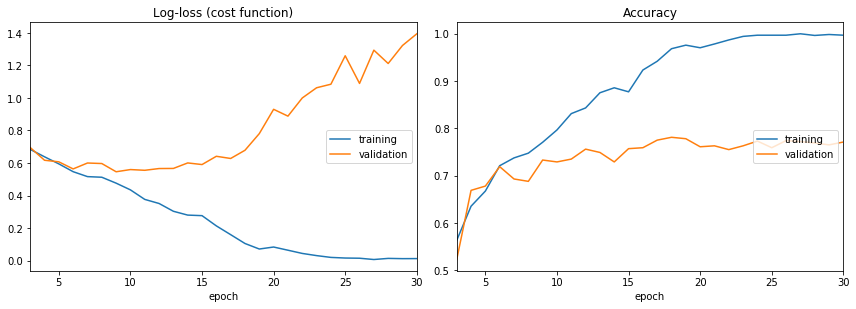

В прошлом практическом задании мы сталкнулись с очень серьезной и важной проблемой в машинном обучении -- переобучении.

Мы получили классификатор с точностью 100% на обучении и 75% на валидации. Такой разрыв очень опасен -- ведь это означает что наша сеть смогла просто "запомнить" правильные ответы на все картинки из трейна.

Есть два основных способа борьбы с переобученим:
1. Увеличение количества данных
2. Уменьшение сложности модели

В нашем случае можно пойти по простому пути -- найти полную версию датасета (он примерно  в 10 раз больше) и обучить сеть. Если есть возможность заполучить больше данных, то ей нужно обязателььно воспользоваться.

Но давайте представим, что у нас нет такой возможности (такой часто случается на практике). Значит нужно попробовать оптимизировать нашу модель.

Давайте это и сделаем.

In [12]:

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# tf.enable_eager_execution()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

BATCH_SIZE = 50
IMG_SHAPE  = 150

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

image_gen_train = ImageDataGenerator(
      rescale=1./255)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Num GPUs Available:  1
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
sample_training_images, sample_labels = next(train_data_gen)

In [14]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    names = {0: "Cat", 1: "Dog"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

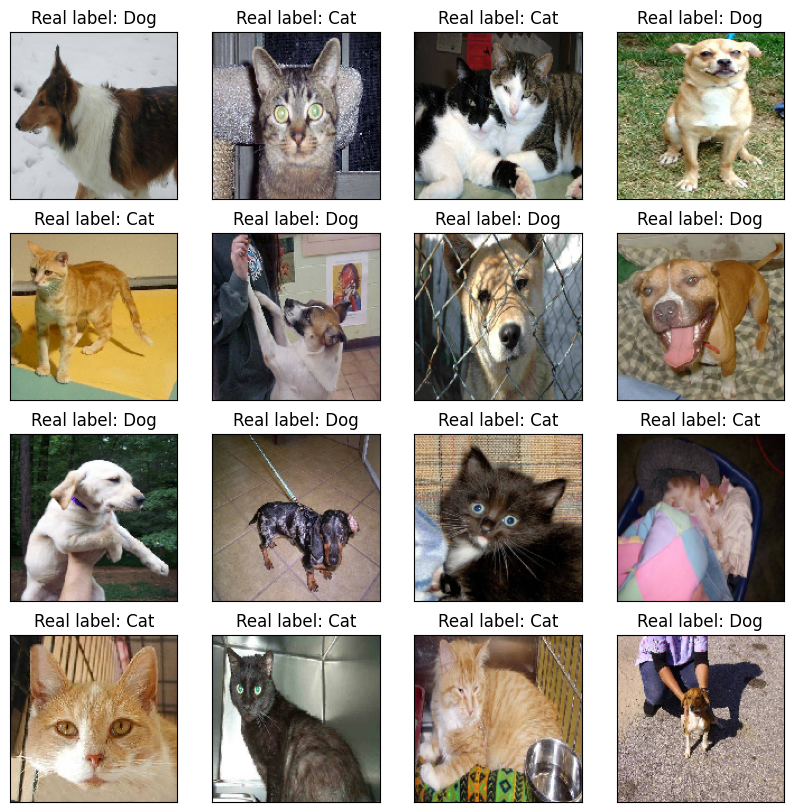

In [15]:
show_catsdogs(sample_training_images, sample_labels)

## Оптимизация модели

Для начала посмотрим на модель, которую мы реализовали в практическом задании:

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,043,905 (3.98 MB)

 Trainable params: 1,043,905 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Обратите внимание на количество параметров в предпоследнем полносвязном слое. Из 800000! Почему? Все из-за того, что Flatten примененный к выходу последнено максполинга с размером (7, 7, 128) превращает его выход в вектор размера 6272. Поэтому, для того чтобы применить к нему полносвязный слой на 128 нейронов, нужно ~ 6272*128~800000 параметров весов.

Можно ли как то "сэкономить"?

Да! Есть еще один очень распространенный сейчас способ перехода от трехмерного тензора после конволюций, к полносвязным слоям -- GlobalAveragePooling. Что это такое можно понять из картинки:

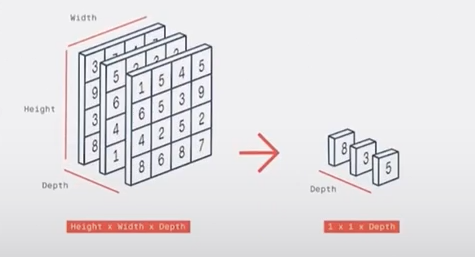

Т.е. он просто считает среднее по каждому из каналов. И мы получим вектор! (точнее тензор размера 1 x 1 x n_channels).


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.GlobalAveragePooling2D(), # добавили GAP
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,473 (1005.75 KB)

 Trainable params: 257,473 (1005.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

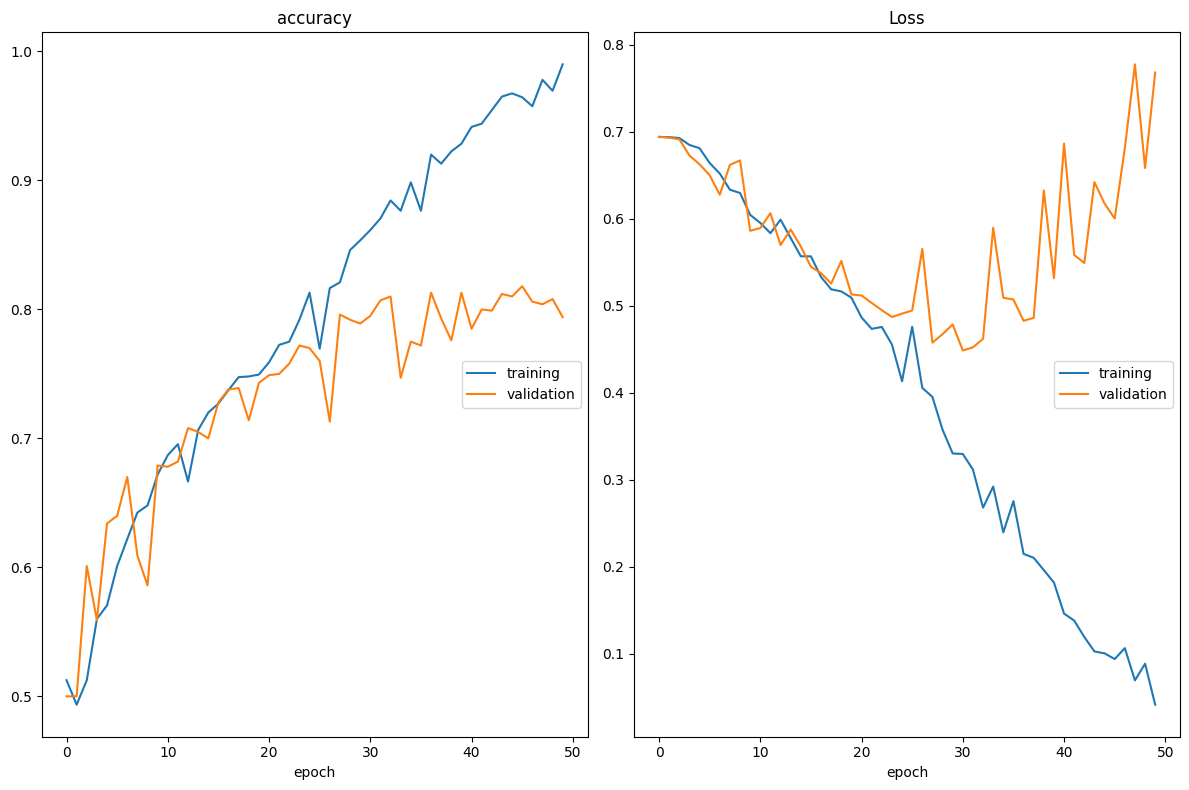

accuracy
	training         	 (min:    0.493, max:    0.990, cur:    0.990)
	validation       	 (min:    0.500, max:    0.818, cur:    0.794)
Loss
	training         	 (min:    0.041, max:    0.694, cur:    0.041)
	validation       	 (min:    0.448, max:    0.777, cur:    0.768)
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9918 - loss: 0.0363 - val_accuracy: 0.7940 - val_loss: 0.7678


In [19]:
EPOCHS = 50
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

Отлично! Теперь переобучение граздо ниже. А точность сравнима с той, что мы получили в практическом заданиие. Можем ли мы еще улучшить?

# Аугментация

Мы обсудили что с переобучением можно бороться или увеличением количества данных или упрощением модели. Упрощение модели мы уже попробовали и предположили, что новых данных у нас нет... Но... <br>
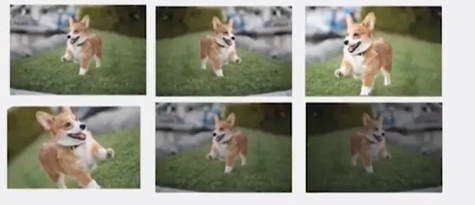

Ведь мы можем немного разнообразить наш датасет с помощью искусственных изменений изображений, которые *не менябт* его класса. Это называется аугментация.

Аугментация искусственно делает датасет более разнообразным, а значит более сложным для "заучивания". Это очень эффективный метод борьбы с переобчуением, но у него конечно есть пределы -- все-таки новых данных мы не добавляем.


Аугментацию в Keras можно добавить буквально в несколько строк:


In [20]:
# так выглядил наш прошлый генератор данных -- он нормализовал изображения
image_gen_no_aug = ImageDataGenerator(rescale=1./255)
sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary',
                                                     )

Found 2000 images belonging to 2 classes.


In [21]:
# а теперь мы попросим его изменять изображение на лету, добавляя повороты, отражения и тд
image_gen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20%
      horizontal_flip=True, # случайное отражение по горизонтали
      fill_mode="constant", # чем заполнять пробелы -- сначала выберем черный цвет, а потом изменим на "nearest"
      cval=0,
      )



sample_aug = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')


Found 2000 images belonging to 2 classes.


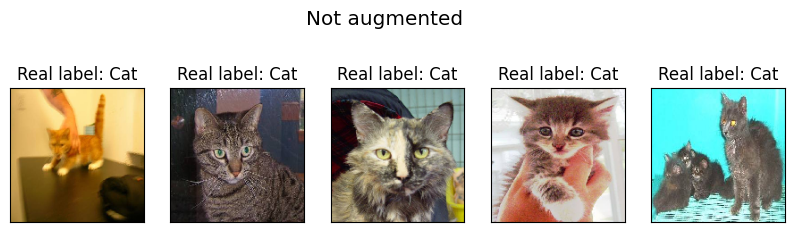

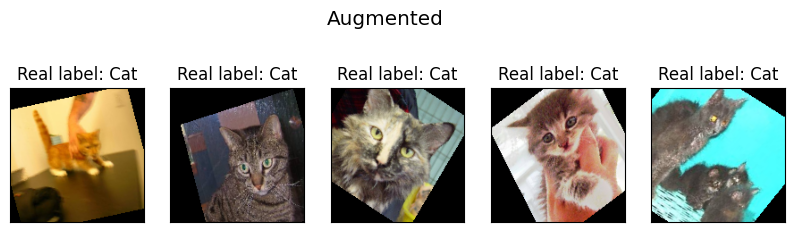

In [22]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(sample_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Augmented")

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.GlobalAveragePooling2D(), # добавили GAP
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

/mnt/500_gb/data_science/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,473 (1005.75 KB)

 Trainable params: 257,473 (1005.75 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
train_image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20%
      horizontal_flip=True, # случайное отражение по горизонтали
      fill_mode="nearest"
      )



train_data_gen = train_image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')


Found 2000 images belonging to 2 classes.


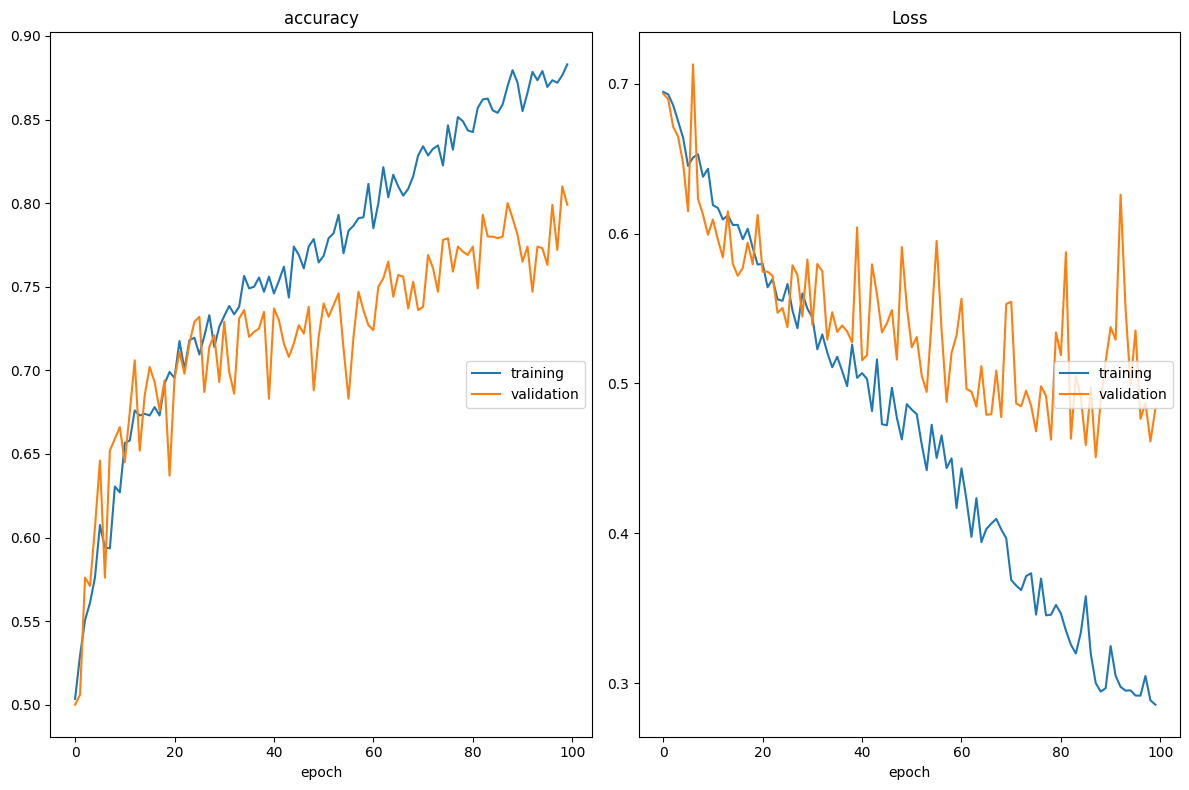

accuracy
	training         	 (min:    0.503, max:    0.883, cur:    0.883)
	validation       	 (min:    0.500, max:    0.810, cur:    0.799)
Loss
	training         	 (min:    0.286, max:    0.695, cur:    0.286)
	validation       	 (min:    0.451, max:    0.713, cur:    0.483)
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.8935 - loss: 0.2633 - val_accuracy: 0.7990 - val_loss: 0.4833


In [25]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

# Заключение

В этом уроке мы познакомились с очень важной темой  -- борьба с переобучением. Мы увидели как на ошибку может влиять размер модели а также добавление (пусть и искуственных) данных.

А ближе к концу модуля мы узнаем как получить на этом датасете точность больше 95%!